In [1]:
import os
import matplotlib.pyplot as plt

from models.GAN import GAN
from utils.loaders import load_safari

In [2]:
# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'camel'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [3]:
(x_train, y_train) = load_safari(DATA_NAME)

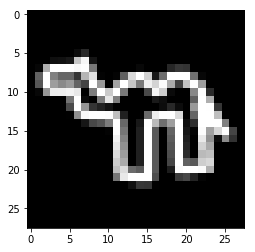

In [4]:
x_train.shape
plt.imshow(x_train[200,:,:,0], cmap = 'gray')

In [5]:
gan = GAN(input_dim = (28,28,1)
        , discriminator_conv_filters = [64, 64, 128, 128]
        , discriminator_conv_kernel_size = [5, 5, 5, 5]
        , discriminator_conv_strides = [2, 2, 2, 1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (7, 7, 64)
        , generator_upsample = [2, 2, 1, 1]
        , generator_conv_filters = [128, 64, 64, 1]
        , generator_conv_kernel_size = [5, 5, 5, 5]
        , generator_conv_strides = [1, 1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimizer = 'rmsprop'
        , z_dim = 100
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [6]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 14, 14, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 7, 7, 64)          102464    
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

Upsampling

VAE의 디코더에서 strides = 2인 Conv2DTranspose 를 사용하여 층마다 텐서의 너비와 높이를 두배로 늘렸다. 이 클래스는 convolution 연산을 수행하기 전에 픽셀 사이에 0을 추가한다.

UpSampling2D 층을 사용하여 텐서의 너비와 높이를 두배로 늘릴수도 있다. 
Conv2DTranspose 와 달리 UpSampling2D는 단순히 입력의 각 행과 열을 반복하여 크기를 두배로 만든다.
그다음 strides = 1인 convolution 을 사용한다. 

이 두가지 방식 모두 원본 이미지 차원으로 돌리는 변환 방법이므로 어느 쪽이 나은 방법인지는 테스트해봐야 한다.
다만 Conv2DTranspose 는 출력 이미지 경계에 계단 모양이나 작은 체크무늬 패턴을 만들 수 있어 출력 품질을 떨어뜨린다고 알려져있다. (Checkerboard Artifacts)
그럼에도 불구하고 여전히 많은 GAN 논문에서 사용하는 방법이다.

In [7]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 14, 14, 128)       2049

In [8]:
BATCH_SIZE = 64
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5

In [9]:
%%time
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)
# epoch, (d_loss), (d_loss_real, d_loss_fake), (d_acc), (d_acc_real, d_acc_fake), g_loss, g_acc (train_on_batch return) 

.594, 0.828)] [G loss: 1.370] [G acc: 0.109]
5807 [D loss: (0.538)(R 0.554, F 0.521)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.458] [G acc: 0.062]
5808 [D loss: (0.580)(R 0.630, F 0.530)] [D acc: (0.734)(0.641, 0.828)] [G loss: 1.292] [G acc: 0.156]
5809 [D loss: (0.576)(R 0.574, F 0.578)] [D acc: (0.664)(0.578, 0.750)] [G loss: 1.253] [G acc: 0.078]
5810 [D loss: (0.557)(R 0.599, F 0.515)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.269] [G acc: 0.141]
5811 [D loss: (0.550)(R 0.608, F 0.492)] [D acc: (0.719)(0.625, 0.812)] [G loss: 1.384] [G acc: 0.125]
5812 [D loss: (0.577)(R 0.585, F 0.568)] [D acc: (0.688)(0.609, 0.766)] [G loss: 1.418] [G acc: 0.078]
5813 [D loss: (0.511)(R 0.571, F 0.452)] [D acc: (0.758)(0.656, 0.859)] [G loss: 1.352] [G acc: 0.078]
5814 [D loss: (0.679)(R 0.541, F 0.816)] [D acc: (0.703)(0.672, 0.734)] [G loss: 1.369] [G acc: 0.047]
5815 [D loss: (0.600)(R 0.698, F 0.502)] [D acc: (0.680)(0.531, 0.828)] [G loss: 1.269] [G acc: 0.125]
5816 [D loss: (0.512)(R 0.54

초록선 : 판별자(진짜)

빨강선 : 판별자(가짜)

검정선 : 판별자(가짜 & 진짜의 평균값)

노랑선 : 생성자

No handles with labels found to put in legend.


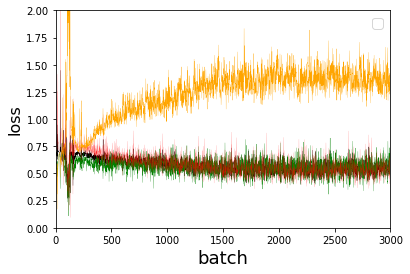

In [22]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.3)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.1)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 3000)
plt.ylim(0, 2)
plt.legend(handles=,fontsize = 'x-large')
plt.show()

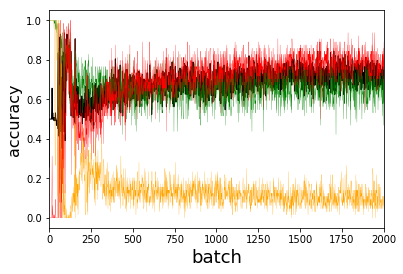

In [19]:
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=1)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()